# Laboratorio: Modelos del lenguaje con RNNs

En este laboratorio, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos en esta laboratorio para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar este laboratorio con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [1]:
import numpy as np 
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import random
import io

path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)

Using TensorFlow backend.


Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [0]:
text = open(path,encoding='UTF-8').read().lower()


Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [3]:
print("Longitud del texto: {}".format(len(text)))
print(text[0:300])

Longitud del texto: 2071198
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


In [0]:
test = text[0:300]
text = text[300:]

## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot 
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot 
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:
 

1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [0]:
unique_characters = set()
for sequence in text:
    for character in sequence:
        unique_characters.add(character)
        

ids = range(len(unique_characters))
char_index_dict = dict(zip(unique_characters, list(ids)))
index_char_dict = dict(zip(list(ids),unique_characters))


#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [0]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []


full_sequence = [text[i:i+j+1] for i in range(len(text)-SEQ_LENGTH) for j in range(SEQ_LENGTH,SEQ_LENGTH+1)]

for sequence in full_sequence:
    sequences.append(sequence[:-1])
    next_chars.append(sequence[-1])


Indicar el tamaño del training set que acabamos de generar.

In [7]:
len(sequences)

2070868

Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [8]:
MAX_SEQUENCES = len(sequences)
MAX_SEQUENCES = 500000
MAX_SEQUENCES = 100000


perm = np.random.permutation(len(sequences))
sequences_short, next_chars_short = np.array(sequences), np.array(next_chars)
sequences_short, next_chars_short = sequences_short[perm], next_chars_short[perm]
sequences_short, next_chars_short = list(sequences_short[:MAX_SEQUENCES]), list(next_chars_short[:MAX_SEQUENCES])

print(len(sequences_short))

100000


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e  **y**  tendrá shape _(num_sequences, num_chars)_. 



In [0]:
NUM_CHARS = len(unique_characters)  # Tu número de caracteres distintos aquí
NUM_SEQUENCES = len(sequences_short)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS))
y = np.zeros((NUM_SEQUENCES, NUM_CHARS))


## Tu código para rellenar X e y aquí. Pista: utilizar el diccionario de
## chars a índices obtenido anteriormente junto con numpy. Por ejemplo,
## si hacemos 
##     X[0, 1, char_to_indices['a']] = 1
## estamos diciendo que para la segunda posición de la primera secuencia se
## tiene una 'a'

# Map each unique character to a one hot encoded array
one_hot = to_categorical(ids)
char_one_hot_dict = dict(zip(unique_characters, list(one_hot)))

for i, character in enumerate(next_chars_short):
    y[i] = char_one_hot_dict[character]
    
for i, sequence in enumerate(sequences_short):
    for j, character in enumerate(sequence):
        X[i][j] = char_one_hot_dict[character]

In [0]:
def encode_text(text, encoding):
    """
    Helper function that encodes given text using encoding (like embedding)
    """
    enc = []
    for i, char in enumerate(text):
        enc.append(encoding[char])
    return np.array(enc)

In [11]:
encode_text(sequences_short[0], char_one_hot_dict)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [0]:
##Gráficas auxiliares para ver la evolución del accuracy y el loss
from matplotlib import pyplot as plt

def plot_acc(history, title="Model Accuracy", ax=None):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)        
    ax.plot(history.history['acc'])
    ax.plot(history.history['val_acc'])
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    
def plot_loss(history, title="Model Loss", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper right')

def plot_training(history):
    # Print learning progress
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  
    plot_acc(history=history, ax=axs[0])
    plot_loss(history=history, ax=axs[1])
    fig.suptitle('Training Progress')

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras import regularizers

NUM_CLASSES = NUM_CHARS
INPUT_SHAPE = X[0].shape

In [14]:
# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
            ]


#regularizer=regularizers.l2(0.01)
##Se crea un pequeño modelo de prueba
model = Sequential()
#model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=TEXT_LEN, trainable=False))
#model.add(Dropout(0.2))
model.add(LSTM(12, input_shape=INPUT_SHAPE))
#model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

W0614 19:24:51.575213 140626678257536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 19:24:51.593229 140626678257536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 19:24:51.595510 140626678257536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12)                3552      
_________________________________________________________________
dense_1 (Dense)              (None, 61)                793       
Total params: 4,345
Trainable params: 4,345
Non-trainable params: 0
_________________________________________________________________


W0614 19:24:51.911030 140626678257536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0614 19:24:51.919034 140626678257536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0614 19:24:52.022259 140626678257536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0614 19:24:52.764159 140626678257536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

Train on 80000 samples, validate on 20000 samples
Epoch 1/3
80000/80000 [==============================] - 61s 757us/step - loss: 3.0138 - acc: 0.1683 - val_loss: 2.8645 - val_acc: 0.2343

Epoch 00001: val_acc improved from -inf to 0.23425, saving model to weights-best.hdf5
Epoch 2/3
80000/80000 [==============================] - 59s 736us/step - loss: 2.7128 - acc: 0.2596 - val_loss: 2.5641 - val_acc: 0.2789

Epoch 00002: val_acc improved from 0.23425 to 0.27895, saving model to weights-best.hdf5
Epoch 3/3
80000/80000 [==============================] - 59s 739us/step - loss: 2.4716 - acc: 0.2962 - val_loss: 2.4104 - val_acc: 0.2895

Epoch 00003: val_acc improved from 0.27895 to 0.28955, saving model to weights-best.hdf5
CPU times: user 4min 5s, sys: 16.6 s, total: 4min 21s
Wall time: 2min 59s


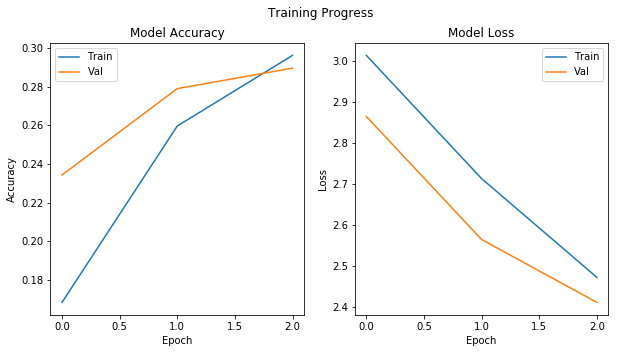

In [15]:
model = model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

%time history = model.fit(X, y, batch_size=64, epochs=3, verbose=1, validation_split=0.2, callbacks=callbacks)
plot_training(history)
plt.show()

Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [0]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [0]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 300

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = seed_text
    
    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.
 
    ### TU CÓDIGO AQUÍ
    generated = predict_text(generated, model, GENERATED_TEXT_LENGTH, char_one_hot_dict)

    ### FIN DE TU CÓDIGO
    return generated



def predict_text(seed_text, model, length, encoding):
    generated = seed_text
    N = len(seed_text)
    for i in range(length):
        text = generated[-N:]
        enc_text = encode_text(text, encoding)
        # Reshape encoded text, because model expects (X, SEQ_LENGTH, NUM_CARS)
        enc_text = np.reshape(enc_text, (1,) + enc_text.shape)
        prediction = model.predict(enc_text)
        predicted_char = index_char_dict[sample(prediction[0])]
        generated += predicted_char
    return generated


def on_epoch_end(epoch, logs):
  print("\n\n\n")
  
  # Primero, seleccionamos una secuencia al azar para empezar a predecir
  # a partir de ella
  start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
  seed_text = text[start_pos:start_pos + SEQ_LENGTH]
  for temperature in TEMPERATURES_TO_TRY:
    print("------> Epoch: {} - Generando texto con temperature {}".format(
        epoch + 1, temperature))
    
    generated_text = generate_text(seed_text, model, 
                                   GENERATED_TEXT_LENGTH, temperature)
    print("Seed: {}".format(seed_text))
    print("Texto generado: {}".format(generated_text))
    print()


generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  

Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


In [18]:
# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
             generation_callback,
            ]


#regularizer=regularizers.l2(0.01)

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.summary()


W0614 19:27:52.236700 140626678257536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 256)           325632    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 61)                15677     
Total params: 866,621
Trainable params: 866,621
Non-trainable params: 0
_________________________________________________________________


Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 117s 1ms/step - loss: 2.4089 - acc: 0.2922 - val_loss: 2.0722 - val_acc: 0.3626

Epoch 00001: val_acc improved from -inf to 0.36260, saving model to weights-best.hdf5




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: o que si me dieran una
sotana 
Texto generado: o que si me dieran una
sotana en a 
llí acjacal las mo
contná, lo pado sinjecaa
dos y pllaches oñra dinto en el no
dicalan a aquecho de padesá- a la nañha les carmilo ven sero tacacám no cos la mompos,
y, de
muveras, y y mus la grragió vertabrano com ridió amos mifintdas sencor, no que mindor, que nablar
o, de se quesal de lan
f

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: o que si me dieran una
sotana 
Texto generado: o que si me dieran una
sotana vecven, quiesta bal ebas la ver lí qué y cababba mebla coesterma el mide lo
la miles, metos 
eb dé musto
trestata décúvo que pástecan a desían 

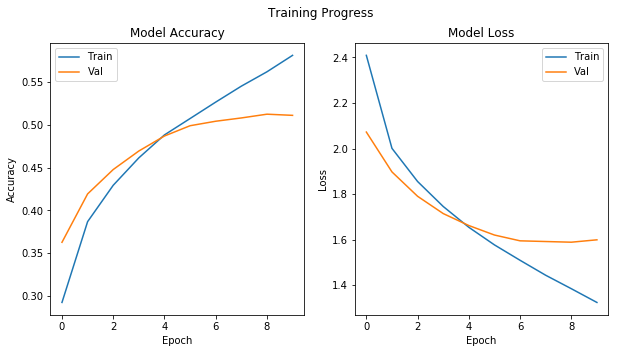

In [19]:
model = model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

%time history = model.fit(X, y, batch_size=64, epochs=10, verbose=1, validation_split=0.2, callbacks=callbacks)

plot_training(history)
plt.show()


In [20]:
# Test
predict_text(test[102:102+SEQ_LENGTH], model, 100, char_one_hot_dict)

'en un lugar de la mancha, de carnera -privela, la vio a la caba?l\nen\nymís, y de sus\neermas y sa calgancia y sólo de aquello\nhigars'

## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.


